In [1]:
from functions import *
from architectures import *

%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


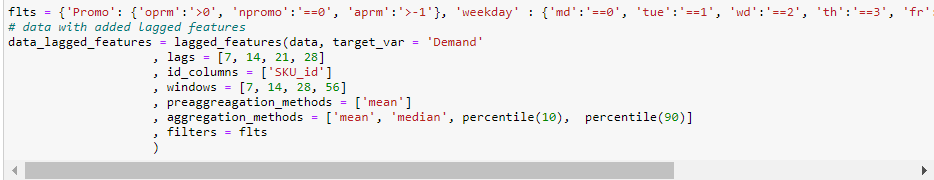

In [115]:
data = pd.read_csv('lagged_pp.csv')

In [3]:
data.head()

,Unnamed: 0,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price,weekday,...,lag21_wdw56_keySKU_id_mean_median_Demand_aprm_anyday,lag28_wdw56_keySKU_id_mean_median_Demand_aprm_anyday,lag7_wdw56_keySKU_id_mean_pctl10_Demand_aprm_anyday,lag14_wdw56_keySKU_id_mean_pctl10_Demand_aprm_anyday,lag21_wdw56_keySKU_id_mean_pctl10_Demand_aprm_anyday,lag28_wdw56_keySKU_id_mean_pctl10_Demand_aprm_anyday,lag7_wdw56_keySKU_id_mean_pctl90_Demand_aprm_anyday,lag14_wdw56_keySKU_id_mean_pctl90_Demand_aprm_anyday,lag21_wdw56_keySKU_id_mean_pctl90_Demand_aprm_anyday,lag28_wdw56_keySKU_id_mean_pctl90_Demand_aprm_anyday
0,0,2015-01-01,1,1,0.0,22.0,163.78,NaN,163.78,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2015-01-02,1,1,0.0,41.0,163.78,NaN,163.78,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2015-01-03,1,1,0.0,35.0,163.78,NaN,163.78,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2015-01-04,1,1,0.0,72.0,163.78,NaN,163.78,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2015-01-05,1,1,0.0,25.0,163.78,NaN,163.78,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Base:

In [12]:
short_lag_cols = data.columns[(data.columns.str.contains('lag')) & (~data.columns.str.contains('lag28'))]
short_lag_cols[:3]

Index(['lag7_wdw7_keySKU_id_mean_mean_Demand_oprm_md',
       'lag14_wdw7_keySKU_id_mean_mean_Demand_oprm_md',
       'lag21_wdw7_keySKU_id_mean_mean_Demand_oprm_md'],
      dtype='object')

In [14]:
data_lagged_features = data.drop(short_lag_cols, axis=1)

In [15]:
df_train, df_test, target_mean, target_stdev, target, features = preprocess(data_lagged_features)

In [16]:
set_random_seed(7)

In [17]:
batch_size = 128
sequence_length = 30

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([128, 30, 390])
Target shape: torch.Size([128])


In [18]:
params = {
    'learning_rate' : 1e-3,
    'weight_decay' : 1e-5,
    'num_hidden_units' : 64,
    'loss_function' : nn.L1Loss(),
    'gamma' : 0,
    'shape' : data_lagged_features.shape,
    'epochs' : 3
}

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=params['num_hidden_units'])
loss_function = params['loss_function']
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['gamma'])

In [19]:
epochs = params['epochs']

train(df_train, epochs, train_loader, train_eval_loader,model,
      loss_function, optimizer, scheduler, batch_size, target_mean, target_stdev)

Epoch 0
---------


100%|███████████████████████████████████████████████████████████████████████| 651/651 [01:10<00:00,  9.29it/s]


Train loss: 0.332591928690443


100%|███████████████████████████████████████████████████████████████████████| 651/651 [00:30<00:00, 21.09it/s]


Smape = 101.33115223446374

Epoch 1
---------


100%|███████████████████████████████████████████████████████████████████████| 651/651 [01:07<00:00,  9.66it/s]


Train loss: 0.2906103754235852


100%|███████████████████████████████████████████████████████████████████████| 651/651 [00:30<00:00, 21.08it/s]


Smape = 90.94527701841064

Epoch 2
---------


100%|███████████████████████████████████████████████████████████████████████| 651/651 [01:08<00:00,  9.50it/s]


Train loss: 0.2907898191894804


100%|███████████████████████████████████████████████████████████████████████| 651/651 [00:29<00:00, 22.12it/s]

Smape = 92.73393867292727



In [20]:
df_out = get_df_out(model, df_train, df_test, train_eval_loader, test_loader, target, target_mean, target_stdev)
ans = get_submission('test_kaggle.csv', df_out)

100%|█████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.25it/s]


In [21]:
ans.to_csv('submission_base.csv', index_label='id')

<AxesSubplot:xlabel='Date'>

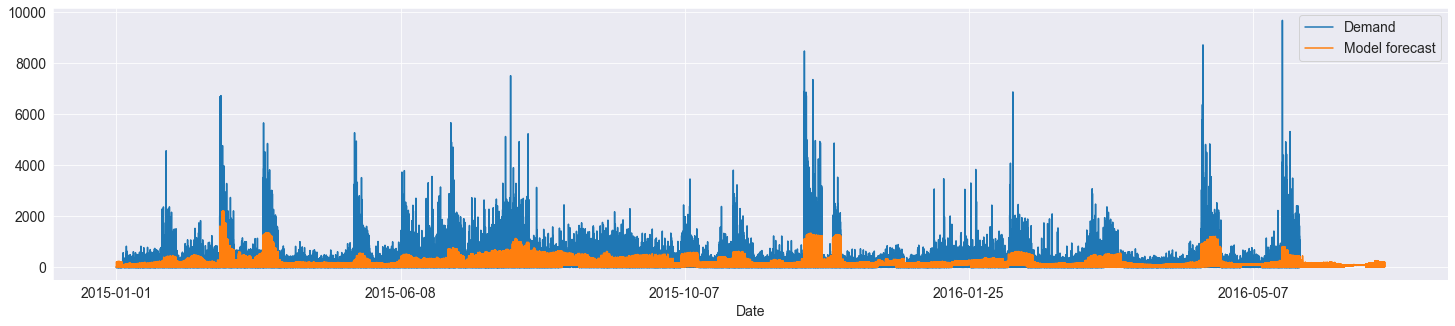

In [22]:
df_out.reset_index().drop(['Store_id', 'SKU_id'], axis=1).set_index('Date').sort_index().plot()

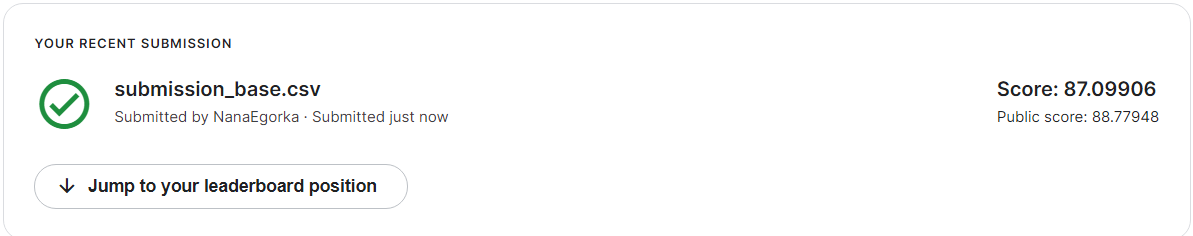

## First week prediction

In [2]:
#data_lagged_features = data.copy(deep=True)
data_lagged_features = pd.read_csv('lagged_pp.csv')

In [3]:
data_lagged_features

,Unnamed: 0,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price,weekday,...,lag21_wdw56_keySKU_id_mean_median_Demand_aprm_anyday,lag28_wdw56_keySKU_id_mean_median_Demand_aprm_anyday,lag7_wdw56_keySKU_id_mean_pctl10_Demand_aprm_anyday,lag14_wdw56_keySKU_id_mean_pctl10_Demand_aprm_anyday,lag21_wdw56_keySKU_id_mean_pctl10_Demand_aprm_anyday,lag28_wdw56_keySKU_id_mean_pctl10_Demand_aprm_anyday,lag7_wdw56_keySKU_id_mean_pctl90_Demand_aprm_anyday,lag14_wdw56_keySKU_id_mean_pctl90_Demand_aprm_anyday,lag21_wdw56_keySKU_id_mean_pctl90_Demand_aprm_anyday,lag28_wdw56_keySKU_id_mean_pctl90_Demand_aprm_anyday
0,0,2015-01-01,1,1,0.0,22.0,163.78,NaN,163.78,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2015-01-02,1,1,0.0,41.0,163.78,NaN,163.78,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2015-01-03,1,1,0.0,35.0,163.78,NaN,163.78,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2015-01-04,1,1,0.0,72.0,163.78,NaN,163.78,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2015-01-05,1,1,0.0,25.0,163.78,NaN,163.78,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92881,92881,2016-06-15,110,2,0.0,NaN,133.06,NaN,133.06,2,...,5.087379,4.524272,3.777503,3.358827,3.051020,3.035714,109.161165,102.456311,97.107012,96.233549
92882,92882,2016-06-16,110,2,0.0,NaN,133.06,NaN,133.06,3,...,5.194175,4.684466,3.890350,3.655742,3.053061,3.035714,110.130097,103.409709,97.398166,96.233549
92883,92883,2016-06-17,110,2,0.0,NaN,133.06,NaN,133.06,4,...,5.300971,4.737864,4.029126,3.625302,3.071429,3.035714,111.099029,104.363107,97.689320,96.233549
92884,92884,2016-06-18,110,2,0.0,NaN,133.06,NaN,133.06,5,...,5.718447,4.737864,4.221765,3.594861,3.069388,3.035714,112.067961,105.316505,98.642718,96.233549


In [48]:
df_train, df_test, target_mean, target_stdev, target, features = preprocess(data_lagged_features)

In [57]:
date_idx = df_test.index.get_level_values('Date')
long_dist = ((pd.to_datetime(date_idx) - pd.to_datetime(date_idx.min())) >= '7 days')

In [58]:
set_random_seed(7)

In [59]:
batch_size = 128
sequence_length = 30

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test[~long_dist],
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([128, 30, 1542])
Target shape: torch.Size([128])


In [60]:
params = {
    'learning_rate' : 1e-3,
    'weight_decay' : 1e-5,
    'num_hidden_units' : 64,
    'loss_function' : nn.L1Loss(),
    'gamma' : 0,
    'shape' : data_lagged_features.shape,
    'epochs' : 3
}

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=params['num_hidden_units'])
loss_function = params['loss_function']
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['gamma'])

In [61]:
epochs = params['epochs']

train(df_train, epochs, train_loader, train_eval_loader,model,
      loss_function, optimizer, scheduler, batch_size, target_mean, target_stdev)

Epoch 0
---------


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [01:30<00:00,  7.19it/s]


Train loss: 0.34126778896668075


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [00:46<00:00, 13.99it/s]


Smape = 104.67780019730093

Epoch 1
---------


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [01:32<00:00,  6.99it/s]


Train loss: 0.30477019732841004


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [00:48<00:00, 13.47it/s]


Smape = 94.22620692309583

Epoch 2
---------


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [01:33<00:00,  6.96it/s]


Train loss: 0.3048702904517636


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [00:47<00:00, 13.78it/s]

Smape = 96.98011110046122



In [62]:
ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = None                                               ##----------------
df_test.loc[~long_dist,ystar_col] = predict(test_loader, model).numpy() ##----------------
df_out = pd.concat((df_train, df_test))[[target, ystar_col]]
for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean


ans = get_submission('test_kaggle.csv', df_out)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


In [78]:
ans.to_csv('first_week.csv', index_label='id')

<AxesSubplot:xlabel='Date'>

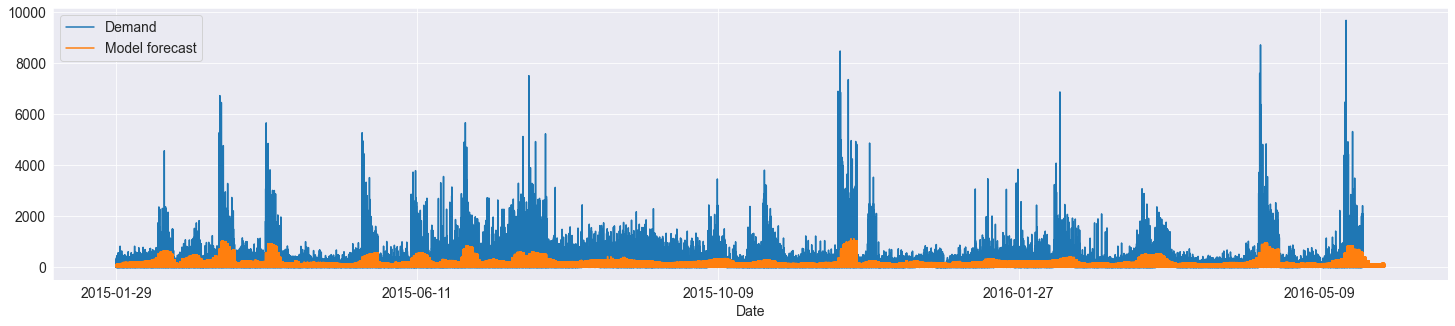

In [66]:
df_out.reset_index().drop(['Store_id', 'SKU_id'], axis=1).set_index('Date').sort_index().plot()

In [79]:
## One model predicts the first week, the second model predicts the rest

base = pd.read_csv('submission_base.csv')
ans.loc[ans['Demand'].isna(), 'Demand'] = base[ans.reset_index()['Demand'].isna()]['Demand'].values
ans.to_csv('ans.csv', index_label='id')

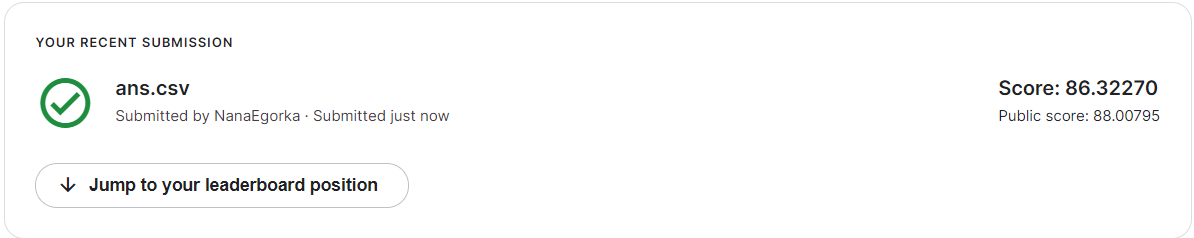

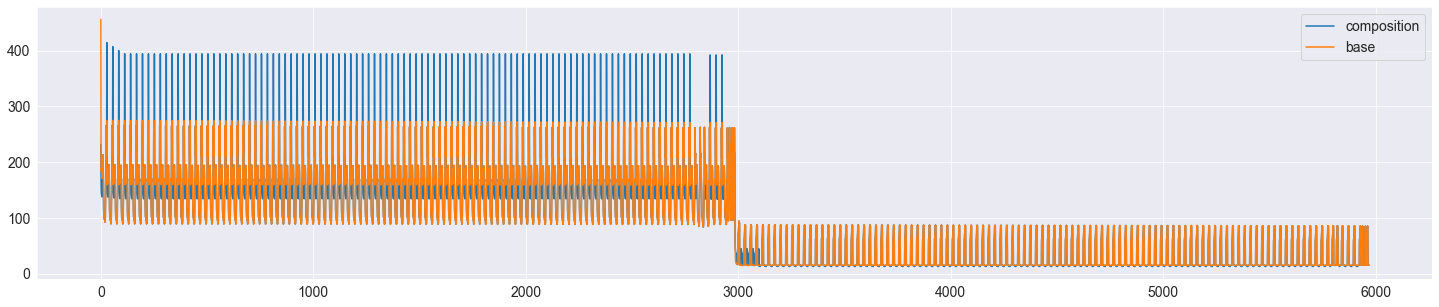

In [105]:
plt.plot(ans.values, label='composition')
plt.plot(base.Demand.values, label='base')
plt.legend()

## Second week prediction

In [123]:
short_lag_cols = data.columns[(data.columns.str.contains('lag')) & (data.columns.str.contains('lag7'))]
short_lag_cols[:3]

Index(['lag7_wdw7_keySKU_id_mean_mean_Demand_oprm_md',
       'lag7_wdw7_keySKU_id_mean_median_Demand_oprm_md',
       'lag7_wdw7_keySKU_id_mean_pctl10_Demand_oprm_md'],
      dtype='object')

In [124]:
data_lagged_features = data.drop(short_lag_cols, axis=1)

In [125]:
df_train, df_test, target_mean, target_stdev, target, features = preprocess(data_lagged_features)

In [126]:
date_idx = df_test.index.get_level_values('Date')
long_dist = ((pd.to_datetime(date_idx) - pd.to_datetime(date_idx.min())) >= '14 days')

In [127]:
set_random_seed(7)

In [128]:
batch_size = 128
sequence_length = 30

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test[~long_dist],
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([128, 30, 1158])
Target shape: torch.Size([128])


In [129]:
params = {
    'learning_rate' : 1e-3,
    'weight_decay' : 1e-5,
    'num_hidden_units' : 64,
    'loss_function' : nn.L1Loss(),
    'gamma' : 0,
    'shape' : data_lagged_features.shape,
    'epochs' : 3
}

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=params['num_hidden_units'])
loss_function = params['loss_function']
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['gamma'])

In [131]:
epochs = params['epochs']

train(df_train, epochs, train_loader, train_eval_loader,model,
      loss_function, optimizer, scheduler, batch_size, target_mean, target_stdev)

Epoch 0
---------


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [01:16<00:00,  8.47it/s]


Train loss: 0.3484343284350119


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [00:38<00:00, 17.04it/s]


Smape = 125.81169922761194

Epoch 1
---------


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [01:17<00:00,  8.37it/s]


Train loss: 0.3122955039833431


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [00:38<00:00, 16.76it/s]


Smape = 94.50800979192594

Epoch 2
---------


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [01:17<00:00,  8.36it/s]


Train loss: 0.3119767128869339


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [00:38<00:00, 16.79it/s]

Smape = 95.71243468738413



In [132]:
ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = None                                               ##----------------
df_test.loc[~long_dist,ystar_col] = predict(test_loader, model).numpy() ##----------------
df_out = pd.concat((df_train, df_test))[[target, ystar_col]]
for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.78it/s]


In [180]:
ans = get_submission('test_kaggle.csv', df_out)

In [181]:
first_week = pd.read_csv('first_week.csv')
first_week.loc[abs(first_week['Demand'] - base['Demand']) < 1e-3, 'Demand'] = None
ans = ans.reset_index()
ans.loc[first_week['Demand'].notna(), 'Demand'] = first_week[first_week['Demand'].notna()]['Demand']
ans.loc[ans['Demand'].isna(), 'Demand'] = base[ans['Demand'].isna()]['Demand']
ans = ans.drop('level_0', axis=1)
ans.to_csv('first_second_week.csv', index_label='id')

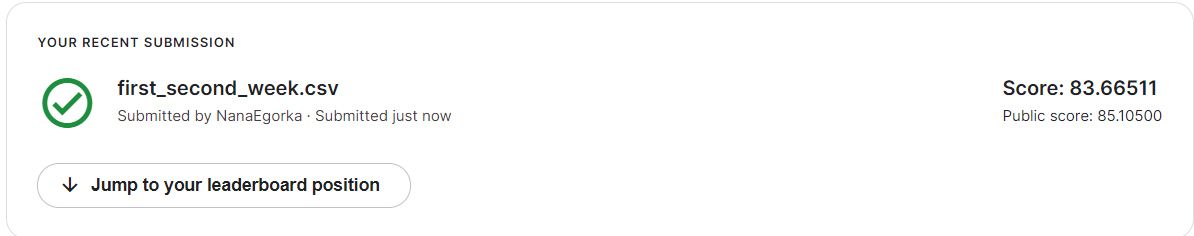

<AxesSubplot:xlabel='Date'>

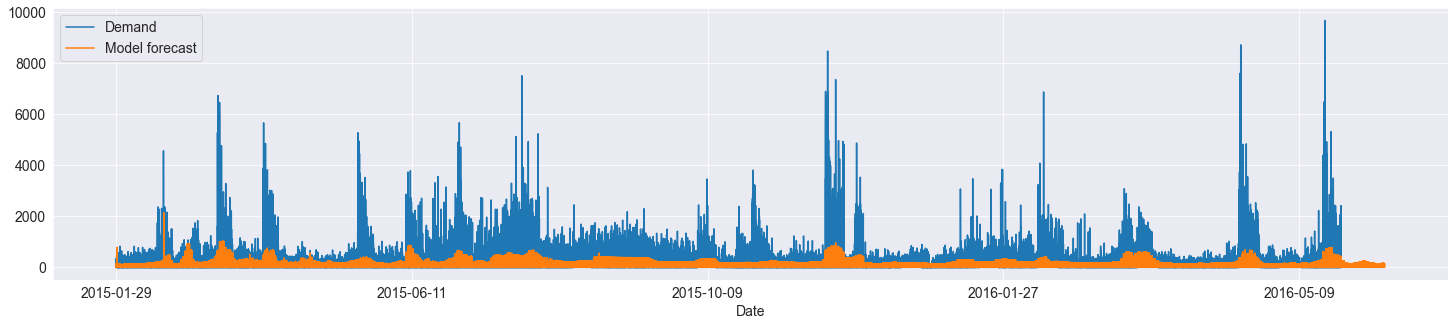

In [182]:
df_out.reset_index().drop(['Store_id', 'SKU_id'], axis=1).set_index('Date').sort_index().plot()

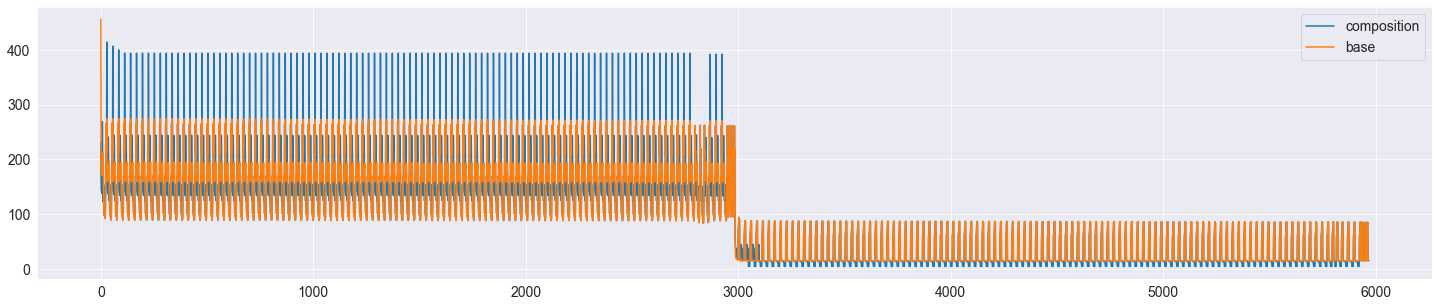

In [183]:
plt.plot(ans.values, label='composition')
plt.plot(base.Demand.values, label='base')
plt.legend()

## Third week prediction

In [184]:
short_lag_cols = data.columns[(data.columns.str.contains('lag')) & ((data.columns.str.contains('lag7')) | (data.columns.str.contains('lag14')))]
short_lag_cols[:3]

Index(['lag7_wdw7_keySKU_id_mean_mean_Demand_oprm_md',
       'lag14_wdw7_keySKU_id_mean_mean_Demand_oprm_md',
       'lag7_wdw7_keySKU_id_mean_median_Demand_oprm_md'],
      dtype='object')

In [185]:
data_lagged_features = data.drop(short_lag_cols, axis=1)

In [186]:
df_train, df_test, target_mean, target_stdev, target, features = preprocess(data_lagged_features)

In [200]:
date_idx = df_test.index.get_level_values('Date')
long_dist = ((pd.to_datetime(date_idx) - pd.to_datetime(date_idx.min())) >= '21 days')

In [201]:
set_random_seed(7)

In [202]:
batch_size = 128
sequence_length = 30

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test[~long_dist],
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([128, 30, 774])
Target shape: torch.Size([128])


In [203]:
params = {
    'learning_rate' : 1e-3,
    'weight_decay' : 1e-5,
    'num_hidden_units' : 64,
    'loss_function' : nn.L1Loss(),
    'gamma' : 0,
    'shape' : data_lagged_features.shape,
    'epochs' : 3
}

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=params['num_hidden_units'])
loss_function = params['loss_function']
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['gamma'])

In [204]:
epochs = params['epochs']

train(df_train, epochs, train_loader, train_eval_loader,model,
      loss_function, optimizer, scheduler, batch_size, target_mean, target_stdev)

Epoch 0
---------


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [01:09<00:00,  9.29it/s]


Train loss: 0.3466472944221747


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [00:33<00:00, 19.10it/s]


Smape = 91.20945977223685

Epoch 1
---------


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [01:10<00:00,  9.20it/s]


Train loss: 0.301738429883564


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [00:33<00:00, 19.23it/s]


Smape = 88.69035482039425

Epoch 2
---------


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [01:11<00:00,  9.05it/s]


Train loss: 0.30185184935912673


100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [00:34<00:00, 18.83it/s]

Smape = 89.48094130887199



In [205]:
ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = None                                               ##----------------
df_test.loc[~long_dist,ystar_col] = predict(test_loader, model).numpy() ##----------------
df_out = pd.concat((df_train, df_test))[[target, ystar_col]]
for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.68it/s]


In [223]:
ans = get_submission('test_kaggle.csv', df_out)

In [211]:
first_second_week = pd.read_csv('first_second_week.csv')
first_second_week.loc[abs(first_second_week['Demand'] - base['Demand']) < 1e-3, 'Demand'] = None
ans = ans.reset_index()
ans.loc[first_second_week['Demand'].notna(), 'Demand'] = first_second_week[first_second_week['Demand'].notna()]['Demand']
ans.loc[ans['Demand'].isna(), 'Demand'] = base[ans['Demand'].isna()]['Demand']
ans = ans.drop('level_0', axis=1)
ans.to_csv('first_second_third_week.csv', index_label='id')

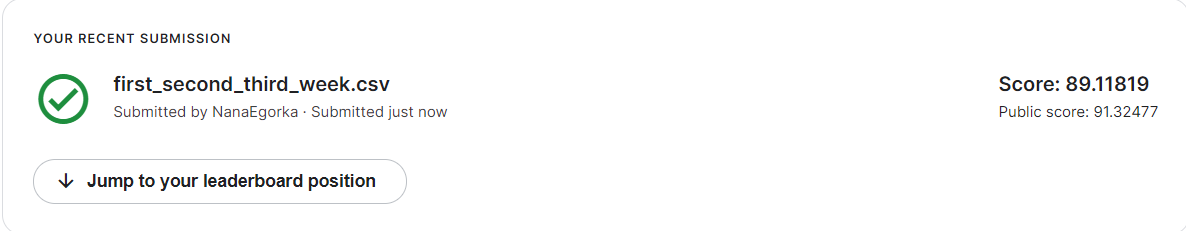

In [226]:
check = base.copy(deep=True)
check.loc[ans.reset_index()['Demand'].notna(), 'Demand'] = ans[ans['Demand'].notna()]['Demand'].values
check = check.drop('id', axis=1)
check.to_csv('check.csv', index_label='id')

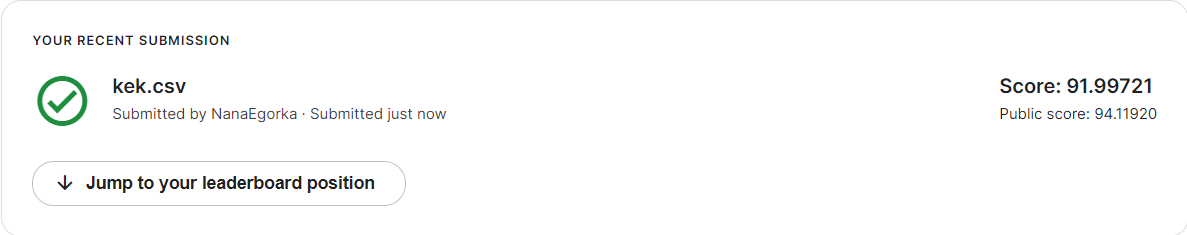

<AxesSubplot:xlabel='Date'>

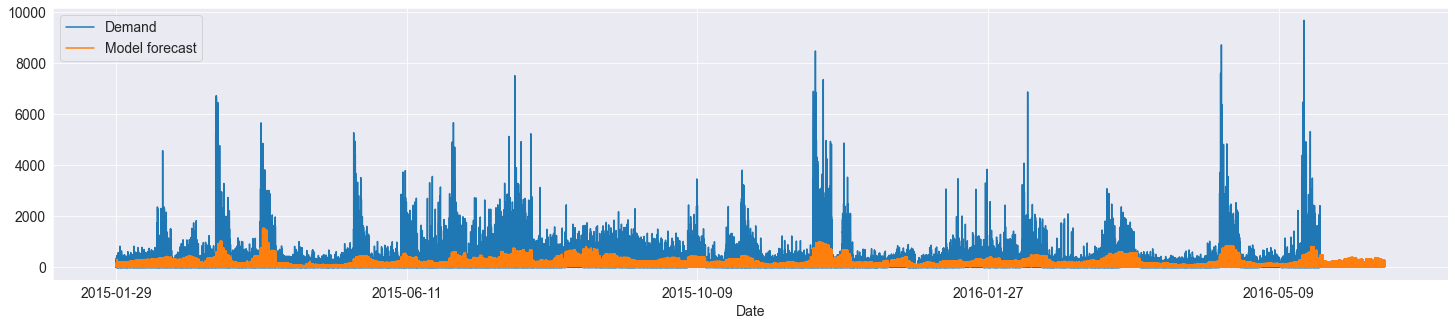

In [227]:
df_out.reset_index().drop(['Store_id', 'SKU_id'], axis=1).set_index('Date').sort_index().plot()

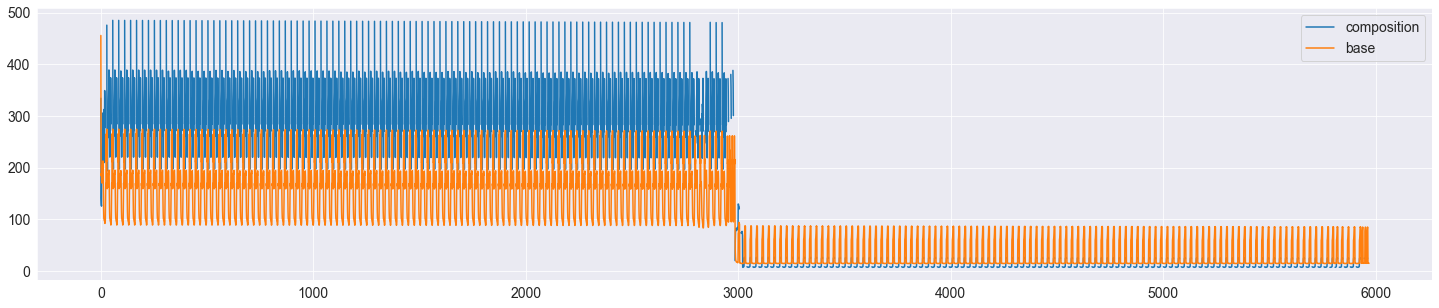

In [228]:
plt.plot(ans.values, label='composition')
plt.plot(base.Demand.values, label='base')
plt.legend()